<a href="https://colab.research.google.com/github/gisalgs/notebooks/blob/main/projections2-colab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# Robinson Projection

>"I started with a kind of artistic approach. I visualized the best-looking shapes and sizes. I worked with the variables until it got to the point where, if I changed one of them, it didn't get any better. Then I figured out the mathematical formula to produce that effect. Most mapmakers start with the mathematics."
>
>Arthur H. Robinson, [The New York Times](http://www.nytimes.com/1988/10/25/science/the-impossible-quest-for-the-perfect-map.html?pagewanted=all&src=pm)


The two projections we discussed so far seemed to be simple as their mathematical work is quite straightforward. However, not all projections are in this way. Here we discuss the [Robinson projection](https://en.wikipedia.org/wiki/Robinson_projection) that requires more computation to transform the points. Here are some characteristics of the Robinson projection:

- The parallels are straight lines and are equally spaced between approximately 38° north and 38° south, but the spacing decreases toward the poles from these two latitudes. 
- The poles in the Robinson projection are straight lines, each being 0.5322 as long as the equator. 
- The central meridian of the projection is a straight line that is 0.5072 as long as the equator. 
- On each parallel, the meridians are equally spaced. 
- The origin of the coordinate system in the Robinson projection is at the intersection between the equator and the central meridian. 

Different from other projections, the Robinson projection relies on the following look-up table for transformation. 

| Latitude ($\varphi$) | Length (A) | Distance to equator (B) |
|:--------------------:|:----------:|:-----------------------:|
|00 | 1.0000 | 0.0000|
|05 | 0.9986 | 0.0620|
|10 | 0.9954 | 0.1240|
|15 | 0.9900 | 0.1860|
|20 | 0.9822 | 0.2480|
|25 | 0.9730 | 0.3100|
|30 | 0.9600 | 0.3720|
|35 | 0.9427 | 0.4340|
|40 | 0.9216 | 0.4958|
|45 | 0.8962 | 0.5571|
|50 | 0.8679 | 0.6176|
|55 | 0.8350 | 0.6769|
|60 | 0.7986 | 0.7346|
|65 | 0.7597 | 0.7903|
|70 | 0.7186 | 0.8435|
|75 | 0.6732 | 0.8936|
|80 | 0.6213 | 0.9394|
|85 | 0.5722 | 0.9761|
|90 | 0.5322 | 1.0000|


From the above look-up table we can also notice a few interesting facts:

- The distance of of each parallel to equator increases by 0.0620 for every 5 degrees from the equator. This number starts to decrease at 40 degree latitude (which would otherwise be 0.4960 if the rate maintains the same but is actually 0.4958). This is because Robinson wanted the polar area to be squeezed a little more as a way to control of area distortion.
- The distance from the pole to equator is 1.0000 as indicated in the table. But from the above we know Robinson wanted the central meridian to be 0.5072 of the length of equator. We will use this table to get the distance of each parallel to equator, but at the end of transformation, we will need to adjust the total length by linear scaling.
- Only the central median is a straight line and all other meridians are curved. We will get the distance of each parallel to equator first and then adjust them so that we can control the length of the meridians (by controlling the length of the central meridian).

For each of the 19 latitudes ranging from 0 to 90 with an interval of 5 degrees (see the table below), Robinson gave the length of each parallel and the map distance from the parallel to the equator. But for any other latitude, we will have to interpolate the length (A) and distance to equator (B). 

Even more interesting and perhaps mysterious, Robinson did not specify which interpolation method was used in his original work. He took an artistic approach to this (see the quote at the beginning of this lecture note). It was suggested by Richardson (1989) that Robinson used Aitken's method in his original work. Aitken's method is now considered to be obsolete and a commonly used method today is called [**Neville's algorithm**](https://en.wikipedia.org/wiki/Neville%27s_algorithm). We will not get to the details of the algorithm, which can be found in the textbook (GIS Algorithms, pp. 35-36). Instead, we will discuss how the code works. We have a main module from the github repo involved here: [transform1.py](https://github.com/gisalgs/geom/blob/master/transform1.py), which imports another module called [neville.py](https://github.com/gisalgs/geom/blob/master/neville.py). We will only need to import the first module (transform1, admittedly the module name can be much improved!) in our own code.

In [1]:
# run the following if necessary
!rm geom -rf
!git clone https://github.com/gisalgs/geom.git 

Cloning into 'geom'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 314 (delta 15), reused 21 (delta 9), pack-reused 287
Receiving objects: 100% (314/314), 58.47 KiB | 2.17 MiB/s, done.
Resolving deltas: 100% (175/175), done.


In [2]:
from geom.transform1 import *

The lookup table is include in this module:

In [3]:
latitudes, A, B

([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90],
 [1.0,
  0.9986,
  0.9954,
  0.99,
  0.9822,
  0.973,
  0.96,
  0.9427,
  0.9216,
  0.8962,
  0.8679,
  0.835,
  0.7986,
  0.7597,
  0.7186,
  0.6732,
  0.6213,
  0.5722,
  0.5322],
 [0.0,
  0.062,
  0.124,
  0.186,
  0.248,
  0.31,
  0.372,
  0.434,
  0.4958,
  0.5571,
  0.6176,
  0.6769,
  0.7346,
  0.7903,
  0.8435,
  0.8936,
  0.9394,
  0.9761,
  1.0])

Technically, an interpolation task will involve a  set of known values and a value used to guess the unknown value. For example, we can provide the height of people at ages of 10, 20, 30, and 40, and we want to estimate (interpolate) the height of someone at the age of 27. The same goes with the look up table above: what is the length of the parallel at latitude 41? Or what is the distance to equator at latitude 17? We do not know these from the look up table and will have to make a guess based on the known values. 

In order to do the interpolation, we first need to decide what known values to be used. We do not want (or need) to use all the known values in the lookup table. We will allow the user to specify this. For example, for each value to be interpolated (say 21), the user wants known values smaller than it and two values greater than it. In other words, we need to pull values (A or B) for latitudes 15, 20, 25, and 30 from the lookup table. There are also special cases to consider. For example, when the interpolation value is 3, we do not have two known values smaller than this, but only one (latitude 0). We need to take care of all the special cases to make sure known values are correctly pulled out from the lookup table. This is done in the two functions called `find_le` and `get_interpolation_range` in the `transform1` module.


The `find_le` function returns the index of the rightmost value in a list that is smaller than or equal to a given value. This function is adopted from [this Python documentation](https://docs.python.org/3/library/bisect.html). We will use this to search for the index of the rightmost value in the latitudes list, which is already sorted and therefore can utilize the binary search method in the bisect module. Here is some tests of this function:

In [4]:
find_le(latitudes, 12.5)

2

In [5]:
find_le(latitudes, 0.1)

0

Once we have got which latitude in the look-up table is the nearest to our input value, we will need to know what are exactly the latitudes, or their indexes rather, that will be used for interpolation. The `get_interpolation_range` function does just that: it returns the start and end indexes given the rightmost smallest value's index and how many do we want on both sizes of the interpolation value. In order to avoid out of range, we also need the total number of items in the list. This function does not need the actual list. The following example shows that indexes used to interpolate a value at 12.5 with two known values smaller and two larger will start at index 1 and end at 5 (included):

In [6]:
i = find_le(latitudes, 12.5)
ileft, iright = get_interpolation_range(2, len(latitudes), i)
print(ileft, iright)

1 5


The actual values are listed below, where 12.5 is right in the middle:

In [7]:
latitudes[ileft:iright]

[5, 10, 15, 20]

With this, we can see how the Neville's algorithm can be used for interpolation the length of the parallel (column A in the lookup table) at latitude 12.5:

In [8]:
neville(latitudes[ileft:iright], A[ileft:iright], 12.5)

0.9929874999999999

This should be a reasonable outcome as the value at latitude 10 is 0.9954, and at latitude 15 is 0.9900. So we got a value that is in between.

Note it will be inappropriate to use the values at latitudes 5, 10, 15, and 20 to interpolate values outside this range. The following is an example to interpolate the length at latitude 80.5 using these four latitudes:

In [9]:
neville(latitudes[ileft:iright], A[ileft:iright], 80.5)

0.6231082999999263

Clearly this is not correct because value at latitude is 0.6213, and the value at 80.5 should be smaller than that, but we got a value that is even greater than that at 80. We should use the proper range:

In [10]:
i = find_le(latitudes, 80.5)
ileft, iright = get_interpolation_range(2, len(latitudes), i)
neville(latitudes[ileft:iright], A[ileft:iright], 80.5)

0.61616005

In [11]:
# TODO
#   What will be the estimate of the distance to equitor 
#   from latitude 33.123 using 3 known values from each side?

lat = 33.123
i = find_le(latitudes, lat)
ileft, iright = get_interpolation_range(3, len(latitudes), i)
neville(latitudes[ileft:iright], B[ileft:iright], lat)

0.41073467744455683

And the actual code for Robinson projection transformation is in the `transform1` function. Applying the code is straightforward, as we did in the other sinusoidal transformation function. Below is a quick test of the function.

In [12]:
transform1(180, 90)

(0.2661, 0.2536)

 Now we should be ready to draw the map.

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

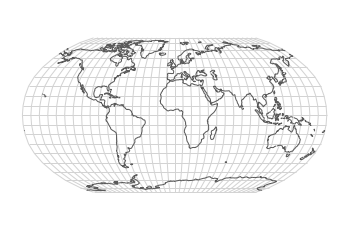

In [14]:
from geom.worldmap import *
from geom.plot_worldmap import *

url = 'https://raw.githubusercontent.com/gisalgs/data/master/ne_110m_coastline.geojson'
raw_points, numgraticule, numline = prep_projection_data(url, _use_lib='URL')

points=[]
for p in raw_points:
    p1 = transform1(p[1], p[2])
    points.append([p[0], p1[0], p1[1]])


# TODO
#   Draw a world map on Robinson Projection
    
_, ax = plt.subplots(1, 1)
plot_world(ax, points, numgraticule, numline)
plt.show()

The above code should render a world map using the Robinson Projection.